In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import matrix_power
from numpy.linalg import eig
from queue import Queue
from IPython.display import Image
import math
from itertools import combinations
import time

In [19]:
def erdos_renyi_graph(N, P): # function which creates erdos renyi graph
    G = nx.Graph() # create graph object
    G.add_nodes_from(range(N)) # add N nodes
    # add edges randomly with probability equals to P
    G.add_edges_from([i for i in combinations(range(N),2) if np.random.binomial(1, P, 1)])    
    return G

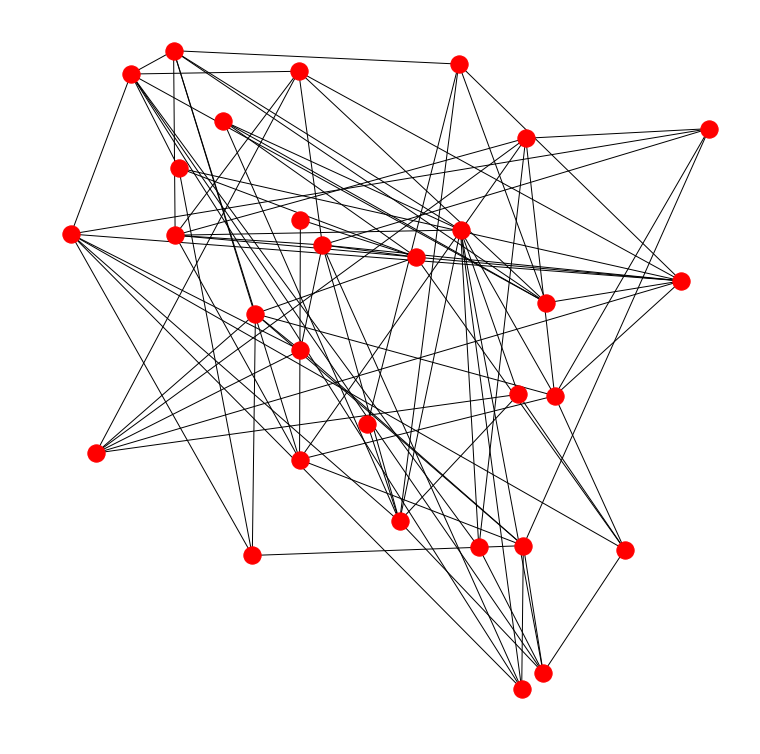

In [84]:
# Let`s create graph with number of nodes which is equal to 30 and the probability of each edge is 0.2 
pER = erdos_renyi_graph(30,0.2)
nx.draw_random(pER)

In [21]:
def random_regular_graph(R,N): # function which creates random regular graph
    # 1) Check if NR is even
    if (N * R) % 2 != 0: raise nx.NetworkXError("N * R must be even")
    # 2) Check if NR is less than N and not negative
    if not 0 <= R < N: raise nx.NetworkXError("the 0 <= R < N inequality must be satisfied")
    if R == 0: return nx.empty_graph(N)
    # 3) Iterate untile the graph is not a regular random graph
    while 1:
        # 4) Generate graph and the list of all possible edges
        G = nx.Graph()
        G.add_nodes_from(range(N))
        all_edges = list(combinations(range(N),2))
        # 5) Itereate untile list of possible edges is empty
        while all_edges:
            # 6) Extract a random edge and add it to the graph
            edge = random.choice(all_edges)
            G.add_edge(edge[0],edge[1])
            # 7) Filter the list of possible edges by removing edges connecting nodes that have maximum degree
            all_edges = list(filter(lambda i: G.degree()[i[0]]<R  and G.degree()[i[1]]<R, all_edges))
            # 8) Filter the list of possible edges by removing edges connecting neighbours
            all_edges = list(filter(lambda i: i[0] not in G.neighbors(i[1]), all_edges))
        # 9) Check if resultig graph is a regular random graph, if not restart from beginning
        if len(list(filter(lambda i: i[1]<R, G.degree()))) == 0: break
    return G

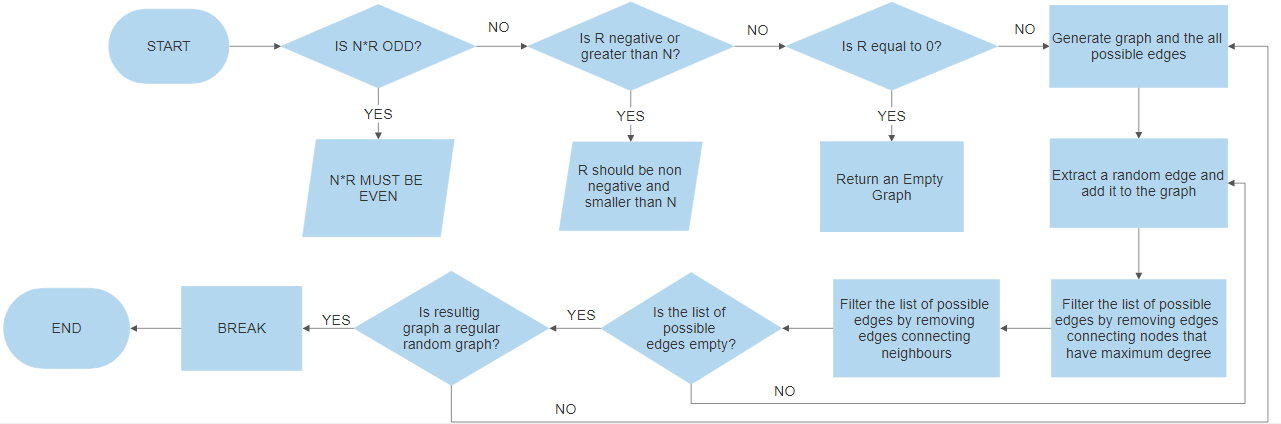

In [22]:
from IPython.display import Image
Image("flowchart.png")

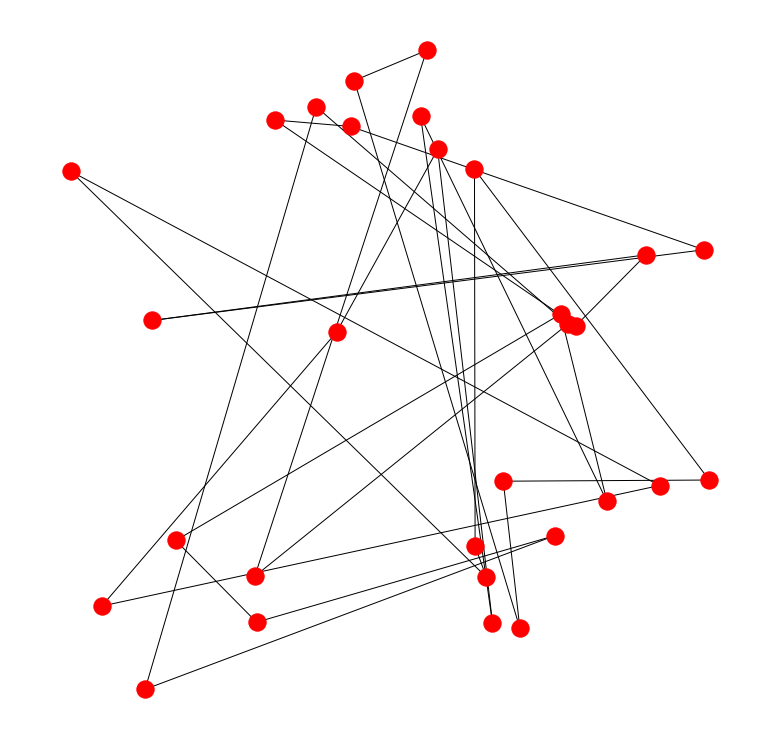

In [83]:
# Let`s create graph with number of nodes which is equal to 30 and the degree of each node is 2 
rRG = random_regular_graph(2, 30)
nx.draw_random(rRG)

In [15]:
def performance(func, arg):# function which computes the execution time of functions
    start = time.time() # start timer
    func(arg) # execute function
    return time.time()-start # stop timer and return the difference

In [66]:
def irreducibility(G): # check connectivity with irreducibility of adjacency matrix
    A = np.array(nx.to_numpy_matrix(G)) # get an adjacency matrix of the graph
    # sum the list of the matrixes in the power from 0 to n-1 and check if the resulting matrix is positive
    if sum([matrix_power(A, i) for i in range(0,len(G.nodes()))]).all() > 0 : return  True 
    else : return False

In [17]:
def laplacian(G): # check connectivity with the second eigenvalue of the laplacian matrix
        L = nx.laplacian_matrix(G).todense() # get a laplacian matrix of the graph
        # get the list of all eigenvalues, sort them pick the second smallest, check its positivity
        if np.sort(eig(L)[0])[1] > 0 : return True 
        else : return False

In [95]:
def BFS(G, srcnode, destnode): # bread first search algorithm
        visited = {i:False for i in G.nodes()} # create dictionary for visited nodes set False as a value for each node
        visited[srcnode] = True # for source node set True as a value (source node is visited)
        predcessor = {i:-1 for i in G.nodes()} # create dictionary for predcessors of each node, set value as -1
        
        q = Queue() # create queue
        q.put(srcnode) # put source node in that queue

        while (q.empty()==False): # iterate while there is some nodes in the queue
                node = q.get() # pick a node from the queue
                for neinode in G.neighbors(node): # for all neighbors of that node do the following
                        if visited[neinode] == False : # check if the node was not visited
                                visited[neinode] = True # mark him as visited
                                predcessor[neinode] = node # define the current node as a predcessor for that neighbor node
                                q.put(neinode) # insert that node into the queue
                        if neinode == destnode: # if the node is our destination node
                                tmp=[] # create temporary list to store all the nodes of the shortest path
                                # while we do not reach the source node (predcessor for source node is always -1)
                                while predcessor[destnode]!=-1: 
                                    tmp.append(destnode) # add ongoing node to the list
                                    destnode = predcessor[destnode] # set predcessor as an ongoing node
                                tmp.append(srcnode) # finally add source node to the list
                                return tmp # return the list of nodes
        # if the destnode is not given then return the list of all visited nodes
        if destnode == None: return list(filter(lambda k: visited[k] == True , visited.keys()))
        # else return the list of nodes when destination node is visited
        else: return list(filter(lambda k: visited[destnode] == True , visited.keys()))

def is_connected(G): # check connectivity using BFS algorithm
    nodes = list(G.nodes()) # create list of all nodes
    # if the set of visited nodes has the same number of nodes as a set of all nodes then graph is connected
    if len(set(BFS(G, random.choice(nodes), None)) & set(nodes)) == len(set(nodes)): return True
    else: return False

def shortest_paths(G): # compute all the shortest paths
    # return the dictionary of tuples of nodes as keys and the list of edges in the shortest path of that nodes 
    return {i:BFS(G, i[0], i[1]) for i in combinations(G.nodes(),2) if len(BFS(G, i[0], i[1])) > 0}

def shortest_paths_length(G): # compute the length of the shortest paths
    return {i:len(BFS(G, i[0], i[1]))-1 for i in combinations(G.nodes(),2) if len(BFS(G, i[0], i[1])) > 0}

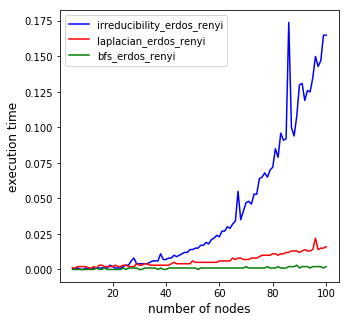

In [96]:
# lists of execution times for several simulations of algorithms 
# which checks the connectivity of the graph (erdos renyi in this case)
irr_er = [performance(irreducibility, erdos_renyi_graph(n,0.2)) for n in range(5,101)]
lap_er = [performance(laplacian, erdos_renyi_graph(n,0.2)) for n in range(5,101)]
bfs_er = [performance(is_connected, erdos_renyi_graph(n,0.2)) for n in range(5,101)]
# plot them together in order to compare
plt.plot(range(5,101),irr_er, 'b', label='irreducibility_erdos_renyi')
plt.plot(range(5,101),lap_er, 'r', label='laplacian_erdos_renyi')
plt.plot(range(5,101),bfs_er, 'g', label='bfs_erdos_renyi')
plt.legend(loc='best')
plt.ylabel('execution time', fontsize=12)
plt.xlabel('number of nodes', fontsize=12)
plt.rcParams["figure.figsize"]=5,5
plt.savefig("complexity.png")
plt.show()

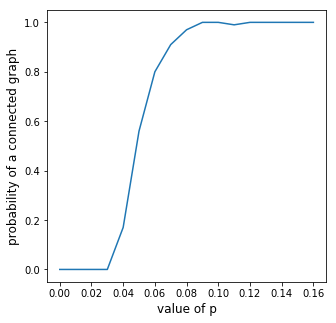

In [97]:
# Probability of a connected graph N=100 i if from (0,17) for each i there are 100 simulations (Erdos-Renyi)
PcG = {i*0.01: sum([int(is_connected(erdos_renyi_graph(100,i*0.01))) for j in range(0,100)])*0.01 for i in range(0, 17)}
plt.plot(list(PcG.keys()),list(PcG.values()))
plt.ylabel('probability of a connected graph', fontsize=12)
plt.xlabel('value of p', fontsize=12)
plt.rcParams["figure.figsize"]=5,5
plt.savefig("connected_graph_prob_erdos_renyi.png")

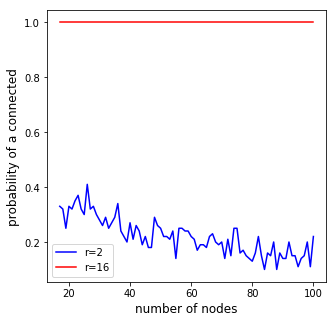

In [98]:
# Probability of a connected graph for n from 17 to 100 and r={2,16} for each n there are 100 simulations
PcG_2 = {n: sum([int(nx.is_connected(nx.random_regular_graph(2, n))) for j in range(100)])/100 for n in range(17,101)}
PcG_16 = {n: sum([int(nx.is_connected(nx.random_regular_graph(16, n))) for j in range(100)])/100 for n in range(17,101)}
    
plt.plot(list(PcG_2.keys()),list(PcG_2.values()), 'b', label='r=2')
plt.plot(list(PcG_16.keys()),list(PcG_16.values()), 'r', label='r=16')

plt.legend(loc='best')

plt.xlabel('number of nodes', fontsize=12)
plt.ylabel('probability of a connected', fontsize=12)
plt.rcParams["figure.figsize"]=5,5
plt.savefig("connected_graph_prob_rand_reg.png")
plt.show()

In [6]:
def mean_path_length(G): # computing mean path length as mean of all the shortest paths in the graph
    return np.mean([i[0] for i in shortest_paths_length(G)])

def number_of_flows(G): # computing number of flows by formula
    N = len(list(G.nodes()))
    return (N/2)*(N-1)

def number_of_links(model, G, R, P): # computing number of links based on the model
    N = len(list(G.nodes()))
    if model == 'rRG': return R*N/2 # formula for random regular graph
    elif model == 'pER': return P*(N/2)*(N-1) # formula for erdos renyi graph
    else: return 'ERROR'

def TH_bound(model, G, R, P): # computing throughput bound for the graph
    m = number_of_links(model, G, R, P)
    h = mean_path_length(G)
    v = number_of_flows(G)
    return m/(h*v) # return the value computed by the formula

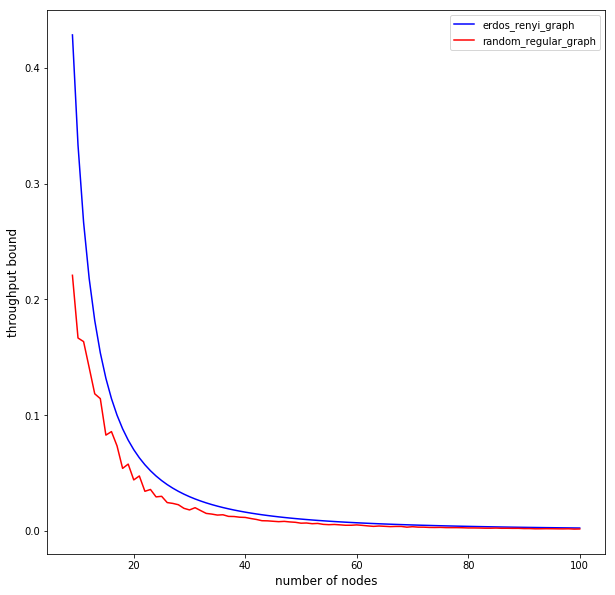

In [74]:
# compute the average throughput bound for each N
tmp_1 = [np.mean([TH_bound('pER', nx.erdos_renyi_graph(N, 8/(N-1)), None, 8/(N-1)) for i in range(10)]) for N in range(9,101)]
tmp_2 = [np.mean([TH_bound('rRG', nx.random_regular_graph(8, N), 8, None) for i in range(10)]) for N in range(9,101)]

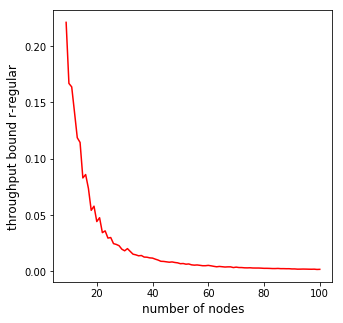

In [101]:
#plt.plot([N for N in range(9,101)], tmp_1, 'b', label='erdos_renyi_graph')
plt.plot([N for N in range(9,101)], tmp_2, 'r', label='random_regular_graph')

#plt.legend(loc='best')

plt.xlabel('number of nodes', fontsize=12)
plt.ylabel('throughput bound r-regular', fontsize=12)
plt.rcParams["figure.figsize"]=5,5
plt.savefig("TH_RG.png")
#plt.show()